# BLOCK-T227 Dynamic Tests Analysis

In [60]:
## Execution for 1%
# block_id = "BLOCK-T227"
# day_obs = 20241026

## Execution for 2%
block_id = "BLOCK-T227"
day_obs = 20241107

In [61]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

from astropy.time import Time
from astropy import units as u
from datetime import datetime

from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import getDayObsStartTime, makeEfdClient
from lsst.summit.utils.tmaUtils import TMAEvent, TMAEventMaker, TMAState

import BLOCK_T227_utils as block

# Create a client to access the Engineering Facility Database
efd_client = makeEfdClient()

# Create an object that mines TMA Slew Events
event_maker = TMAEventMaker()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
day_obs = int(day_obs)
start_time = getDayObsStartTime(day_obs)
end_time = start_time + 1 * u.day

print(
    f"\nQuery data for {day_obs}"
    f"\n  starts at {start_time.isot} and"
    f"\n  ends at {end_time.isot}\n"
)


Query data for 20241107
  starts at 2024-11-07T12:00:00.000 and
  ends at 2024-11-08T12:00:00.000



## Querying data

I tottally forgot that a [Script] will not publish metadata.  
The only way we can have BLOCK metadata is by running BLOCKs via Scheduler.  
Now what? Meh... Let's work with timestamps.  

[Script]: https://ts-xml.lsst.io/sal_interfaces/Script.html

In [63]:
# From OLE
start_time = Time("2024-11-08T06:12:09.475436")
end_time = Time("2024-11-08T06:50:45.025632")


   
The cell bellow will query all the TMAEvents.  
The easiest way I found to query the data associated with this test was to query everything and filter later. 

In [64]:
events = event_maker.getEvents(day_obs)

Alright, now we can filter our slew events using the timestamps above. 

In [65]:
# We are working with lists 
mask_begin = np.array([evt.begin >= start_time for evt in events])
mask_end = np.array([evt.end <= end_time for evt in events])
mask = mask_begin & mask_end

events = np.array(events)
filtered_events = events[mask]

print(f"Found {filtered_events.size} TMA Slew Events")

Found 17 TMA Slew Events


Now we query the measured forces on the hardpoints during all of these TMA events.   
We are interested in the minimum and maximum values they can reach. 

In [66]:
df_hp_forces = block.get_hp_minmax_forces(efd_client, filtered_events, verbose=False)

In [67]:
df_hp_forces.round()

,seq_num,delta_az,delta_el,min_forces,max_forces
0,80,91.0,0.0,-85.0,66.0
1,81,0.0,12.0,-39.0,171.0
2,82,-0.0,-12.0,-187.0,59.0
3,83,24.0,-0.0,-66.0,81.0
4,84,-24.0,0.0,-70.0,76.0
5,85,0.0,3.0,-37.0,176.0
6,86,0.0,-3.0,-184.0,58.0
7,87,3.0,-0.0,-69.0,82.0
8,88,-3.0,0.0,-77.0,77.0
9,89,8.0,8.0,-98.0,180.0


Alright, those values make sense. Now let's plot the histogram. There is not much data. But we should see something. 

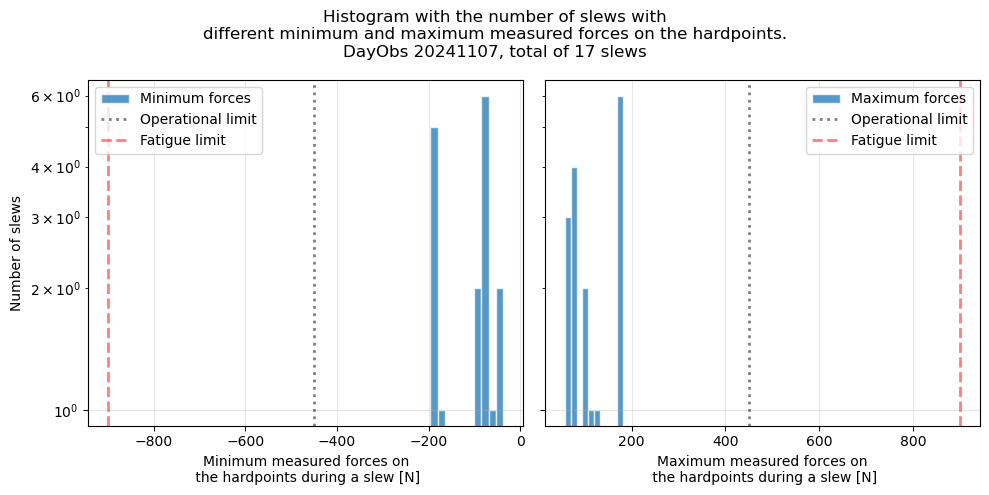

In [68]:
%matplotlib inline 
block.plot_histogram_hp_minmax_forces(df_hp_forces, day_obs)